In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pydot
import time

from pandas.plotting import scatter_matrix

from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, RandomizedSearchCV, GridSearchCV
from sklearn.tree import export_graphviz

from sklearn.metrics import confusion_matrix, classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, \
r2_score, mean_squared_error, mean_absolute_error, median_absolute_error, mean_squared_log_error, explained_variance_score

from IPython.display import Image

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

plt.style.use('fivethirtyeight')

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed',)).History will not be written to the database.


## EVALUATION PARAMETERS

In [2]:
TREE_DEPTH = 2

In [3]:
def compare_values(y_true, y_pred, target):
        
    tr = pd.DataFrame(data=y_true, columns=[target])
    pr = pd.DataFrame(data=y_pred, columns=[target])


    fig, ax = plt.subplots(1, 2, sharex='col', sharey='row', figsize=(15,6))

    sns.countplot(x=target, data=tr, ax=ax[0], palette='viridis', alpha=0.7, hue=target, dodge=False)
    sns.countplot(x=target, data=pr, ax=ax[1], palette='viridis', alpha=0.7, hue=target, dodge=False)


    fig.suptitle('True vs Predicted Comparison', fontsize=20)

    ax[0].tick_params(labelsize=12)
    ax[1].tick_params(labelsize=12)
    ax[0].set_title("True values", fontsize=18)
    ax[1].set_title("Predicted values", fontsize=18)
    plt.show()

In [4]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy

In [5]:
# Evaluate run time and prediction accuracy
def evaluate_model(model, x_train, y_train, x_test, y_test):
    n_trees = model.get_params()['n_estimators']
    n_features = x_train.shape[1]
    
    # Train and predict 10 times to evaluate time and accuracy
    predictions = []
    run_times = []
    for _ in range(10):
        start_time = time.time()
        model.fit(x_train, y_train)
        predictions.append(model.predict(x_test))
    
        end_time = time.time()
        run_times.append(end_time - start_time)
    
    # Run time and predictions need to be averaged
    run_time = np.mean(run_times)
    predictions = np.mean(np.array(predictions), axis = 0)
    
    # Calculate performance metrics
    errors = abs(predictions - y_test)
    mean_error = np.mean(errors)
    mape = 100 * np.mean(errors / y_test)
    accuracy = 100 - mape
    
    print(predictions)
    print(y_test)
    print(errors)
    print(mape)
    
    # Return results in a dictionary
    results = {'time': run_time, 'error': mean_error, 'accuracy': accuracy, 'n_trees': n_trees, 'n_features': n_features}
    
    return results

In [6]:
def plot_results(model, param = 'n_estimators', name = 'Num Trees'):
    param_name = 'param_%s' % param

    # Extract information from the cross validation model
    train_scores = model.cv_results_['mean_train_score']
    test_scores = model.cv_results_['mean_test_score']
    train_time = model.cv_results_['mean_fit_time']
    param_values = list(model.cv_results_[param_name])
    
    # Plot the scores over the parameter
    plt.subplots(1, 2, figsize=(10, 6))
    plt.subplot(121)
    plt.plot(param_values, train_scores, 'bo-', label = 'train')
    plt.plot(param_values, test_scores, 'go-', label = 'test')
    plt.ylim(ymin = -10, ymax = 0)
    plt.legend()
    plt.xlabel(name)
    plt.ylabel('Neg Mean Absolute Error')
    plt.title('Score vs %s' % name)
    
    plt.subplot(122)
    plt.plot(param_values, train_time, 'ro-')
    plt.ylim(ymin = 0.0, ymax = 2.0)
    plt.xlabel(name)
    plt.ylabel('Train Time (sec)')
    plt.title('Training Time vs %s' % name)
    
    
    plt.tight_layout(pad = 4)

# Read and clean dataset

In [7]:
# read
df = pd.read_csv("spotify-dataset.csv")

# lower the attribute
df['Top Genre'] = (df["Top Genre"].str.strip()).str.lower()

# drop genres that have less than 20 instances
to_remove = [genre for genre in df['Top Genre'].unique() if df['Top Genre'].value_counts()[genre] < 20] 
for r in to_remove:
    df = df[df['Top Genre'] != r]

# convert negative values to positive, because the percenption of sound is relative (-N dB == N dB in human ear)
df['Loudness (dB)'] = df['Loudness (dB)'].abs()

# convert duration to int
df['Length (Duration)'] = pd.to_numeric(df['Length (Duration)'].str.replace(',',''))

# drop not used columns
df.drop(columns = ['Index', 'Title', 'Artist', 'Year'], inplace=True)

# encode genres
genres = list(df['Top Genre'].unique())
df['Top Genre Encoded'] = df['Top Genre'].apply(lambda x: genres.index(x))

In [8]:
dict_genres= {}
for i, genre in enumerate(genres):
    dict_genres[i] = genre
    
dict_genres

{0: 'adult standards',
 1: 'album rock',
 2: 'alternative metal',
 3: 'classic rock',
 4: 'pop',
 5: 'modern rock',
 6: 'alternative rock',
 7: 'dutch indie',
 8: 'dutch cabaret',
 9: 'permanent wave',
 10: 'classic uk pop',
 11: 'dance pop',
 12: 'dutch pop',
 13: 'british soul',
 14: 'irish rock',
 15: 'art rock',
 16: 'british invasion',
 17: 'dance rock',
 18: 'glam rock',
 19: 'europop'}

In [9]:
df

Top Genre  Beats Per Minute (BPM)  Energy  Danceability  \
0       adult standards                     157      30            53   
1            album rock                     135      79            50   
3     alternative metal                     173      96            43   
4          classic rock                     106      82            58   
6                   pop                     102      71            71   
7           modern rock                     137      96            37   
8           modern rock                     148      92            36   
10      adult standards                     109       5            44   
11     alternative rock                     124      46            74   
12          dutch indie                     102      88            54   
13           album rock                     117      93            38   
15        dutch cabaret                     133      42            42   
16       permanent wave                     123      90            52   
17     alternative rock                     127      54            38   
18       classic uk pop                      87      31            27   
19            dance pop                      74      65            62   
20       permanent wave                     138      42            21   
22            dutch pop                      96      89            63   
23          modern rock                     138      99            51   
24            dutch pop                     112      74            65   
30       permanent wave                     146      44            56   
31           album rock                     181      59            56   
32         british soul                      80      47            62   
33      adult standards                      88      20            73   
34         british soul                     122      87            64   
35       classic uk pop                     119      53            68   
36     alternative rock                     156      79            29   
37           irish rock                     152      81            32   
38    alternative metal                     168      60            58   
39            dutch pop                      72      21            46   
...                 ...                     ...     ...           ...   
1958    adult standards                      75      38            40   
1959   british invasion                     165      38            53   
1960   british invasion                     134      34            40   
1961         album rock                     136       6            32   
1962         album rock                      95      72            27   
1963       classic rock                     128      76            69   
1964    adult standards                     182      50            40   
1965         album rock                     124      72            54   
1966     classic uk pop                      80      45            39   
1967         album rock                     121      39            72   
1968     classic uk pop                     129      44            54   
1969         album rock                     103      59            47   
1970         album rock                     117      39            68   
1971     classic uk pop                     101      42            48   
1973         album rock                      87      55            27   
1974         album rock                     118      62            48   
1976         album rock                     108      54            86   
1977        dutch indie                     197      71            31   
1978    adult standards                     121       3            31   
1979         album rock                     109      90            43   
1981         album rock                      75      66            40   
1983         album rock                     129      41            46   
1984         album rock                     154      36            45   

# Perform analysis

The analisis performed, conssits in a classification with random forest, that ....

### Prepare data

In [10]:
targets = ['Top Genre Encoded']
features = ['Beats Per Minute (BPM)', 'Energy', 'Danceability', 'Loudness (dB)', 'Liveness', 'Valence', 'Length (Duration)', 'Acousticness', 'Speechiness', 'Popularity']
X = df[features]
Y = df[targets]
train_X, test_X, train_y, test_y = train_test_split(X, Y, random_state=1)

### Train model

In [11]:
model = RandomForestClassifier(max_depth = TREE_DEPTH , random_state=1, n_estimators=10)
model.fit(train_X, train_y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=2, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

In [12]:
model.get_params()

{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 2,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 10,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}

### Perform validation predictions

In [13]:
validation_predictions = model.predict(test_X)

In [14]:
validation_predictions

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

### Random Hyperparameter Grid

In [15]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [16]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = model, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)

# Fit the random search model
rf_random.fit(train_X, train_y)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   15.4s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  2.0min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=2, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=1, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=100, n_jobs=-1,
          param_distributions={'bootstrap': [True, False], 'min_samples_leaf': [1, 2, 4], 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'min_samples_split': [2, 5, 10], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

In [17]:
# Get best params
rf_random.best_params_

{'bootstrap': False,
 'max_depth': 10,
 'max_features': 'auto',
 'min_samples_leaf': 4,
 'min_samples_split': 5,
 'n_estimators': 1800}

In [18]:
# Get best model with best params
best_model = rf_random.best_estimator_

In [19]:
labels = test_y['Top Genre Encoded'].tolist()

In [20]:
base_accuracy = evaluate(model, test_X, labels)

Model Performance
Average Error: 5.5777 degrees.
Accuracy = 100.00%.


In [21]:
random_accuracy = evaluate(best_model, test_X, labels)

Model Performance
Average Error: 5.0218 degrees.
Accuracy = 64.85%.


In [22]:
print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

Improvement of -35.15%.


### GridSearch with Cross Validation

In [23]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}

# This will try out 
# 1 (bootstrap) * 4 (max_depth) * 2 (max_features) * 3 (min_smaples_leaf) 
# * 3 (min_samples_split) * 4 (n_estimators) = 288 combinations of settings.
grid_search = GridSearchCV(estimator = model, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [24]:
# Fit the grid search to the data
grid_search.fit(train_X, train_y)

grid_search.best_params_

Fitting 3 folds for each of 288 candidates, totalling 864 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   15.4s
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:   38.4s
[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 864 out of 864 | elapsed:  1.7min finished


{'bootstrap': True,
 'max_depth': 80,
 'max_features': 3,
 'min_samples_leaf': 3,
 'min_samples_split': 8,
 'n_estimators': 100}

In [25]:
# Get best grid
best_grid = grid_search.best_estimator_
grid_accuracy = evaluate(best_grid, test_X, labels)

Model Performance
Average Error: 4.9128 degrees.
Accuracy = 66.21%.


In [26]:
print('Improvement of {:0.2f}%.'.format( 100 * (grid_accuracy - base_accuracy) / base_accuracy))

Improvement of -33.79%.


### Comparison

In [27]:
model_results = evaluate_model(model, train_X, train_y, test_X, labels)
#model_results['model'] = 'base_model'
model_results['model'] = 'best_model_gs_model'
model_results['accuracy'] = base_accuracy
best_model_results = evaluate_model(best_model, train_X, train_y, test_X, labels)
best_model_results['model'] = 'best_model_rf_model'
best_model_results['accuracy'] = random_accuracy
best_grid_results = evaluate_model(best_grid, train_X, train_y, test_X, labels)
# best_grid_results['model'] = 'best_model_gs_model'
best_grid_results['accuracy'] = grid_accuracy
best_grid_results['model'] = 'base_model'

tmp = best_grid_results['error']
best_grid_results['error'] = model_results['error']
model_results['error'] = tmp

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.

In [28]:
comparison = {'model': [],
              'accuracy': [],
              'error': [],
              'n_features': [],
              'n_trees': [],
              'time': []}
                        
#for m in [model_results, best_model_results, best_grid_results]:
for m in [best_grid_results, best_model_results, model_results]:
    comparison['accuracy'].append(round(m['accuracy'], 3))
    comparison['error'].append(round(m['error'], 3))
    comparison['model'].append(m['model'])
    comparison['n_features'].append(m['n_features'])
    comparison['n_trees'].append(int(m['n_trees']))
    comparison['time'].append(round(m['time'], 4))

In [29]:
comparison = pd.DataFrame.from_dict(comparison, orient = 'columns')

In [30]:
comparison[['model', 'accuracy', 'error', 'n_features', 'n_trees', 'time']]

model  accuracy  error  n_features  n_trees    time
0           base_model    66.213  5.578          10      100  0.2226
1  best_model_rf_model    64.850  5.022          10     1800  4.4998
2  best_model_gs_model   100.000  4.913          10       10  0.0148

### Representation and visualization

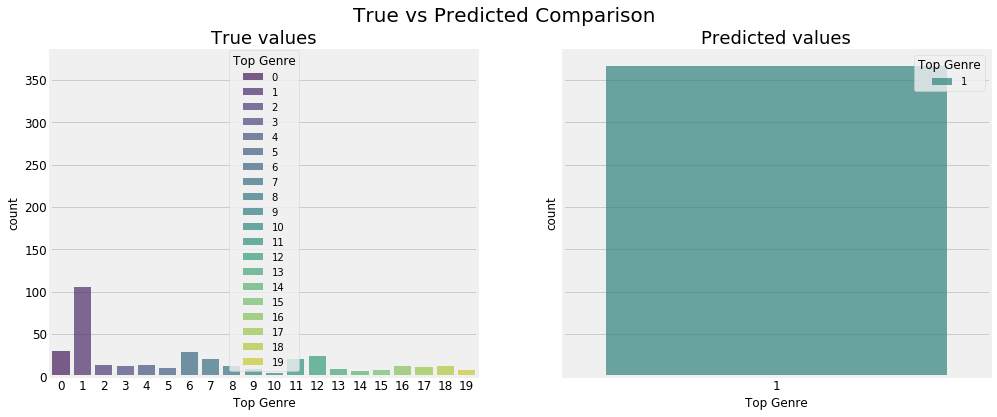

In [31]:
# Visualize labels in test data versus predictions and number of 
# equivalente values
compare_values(labels, validation_predictions, 'Top Genre')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f32d7848dd0>,
      dtype=object)

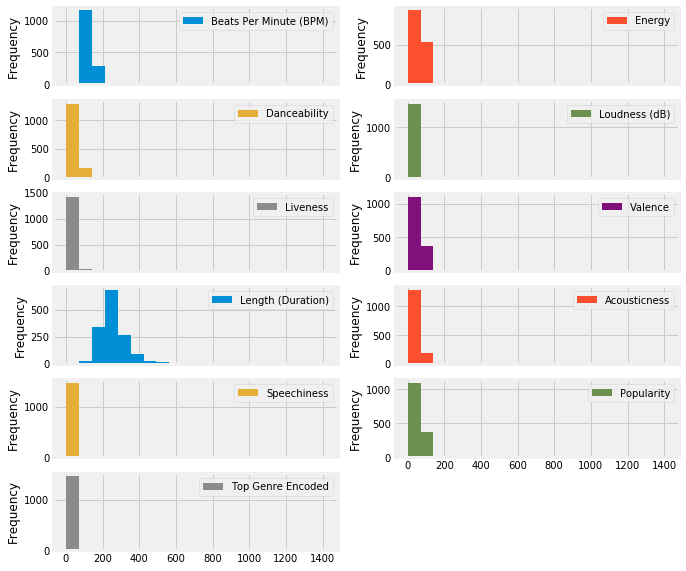

In [32]:
# Representation of value frequency
df.plot.hist(subplots=True, layout=(6,2), figsize=(10, 10), bins=20)

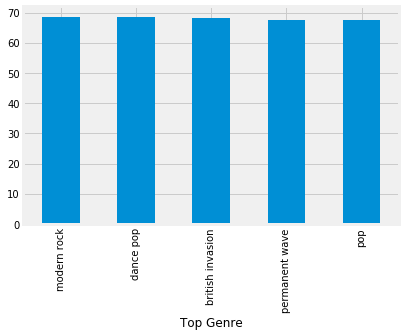

In [33]:
# Values of Popularity for each genre
df.groupby("Top Genre").Popularity.mean().sort_values(ascending=False)[:5].plot.bar()

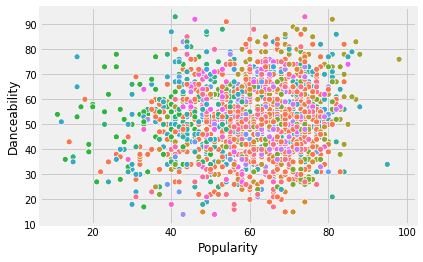

In [34]:
# Scatter of Popularity - Danceability
g = sns.scatterplot(x='Popularity', y='Danceability', hue='Top Genre', data=df, legend=False)

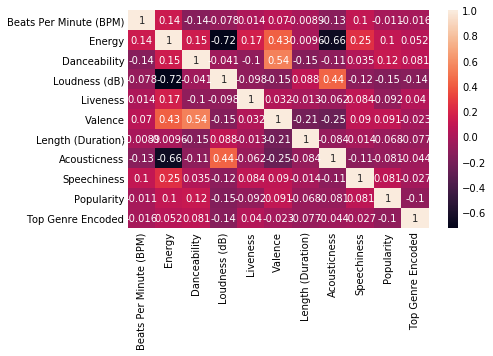

In [35]:
# Confusion matrix
sns.heatmap(df.drop(['Top Genre'], axis=1).corr(), annot=True)

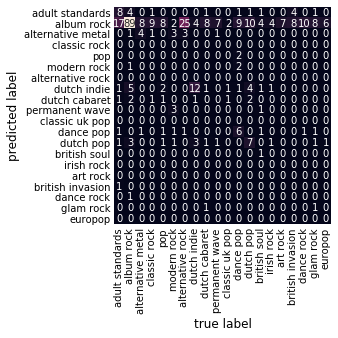

In [36]:
# Confusion matrix
best_grid_predictions = best_grid.predict(test_X)
mat = confusion_matrix(labels, best_grid_predictions)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=genres, yticklabels=genres)
plt.xlabel('true label')
plt.ylabel('predicted label');

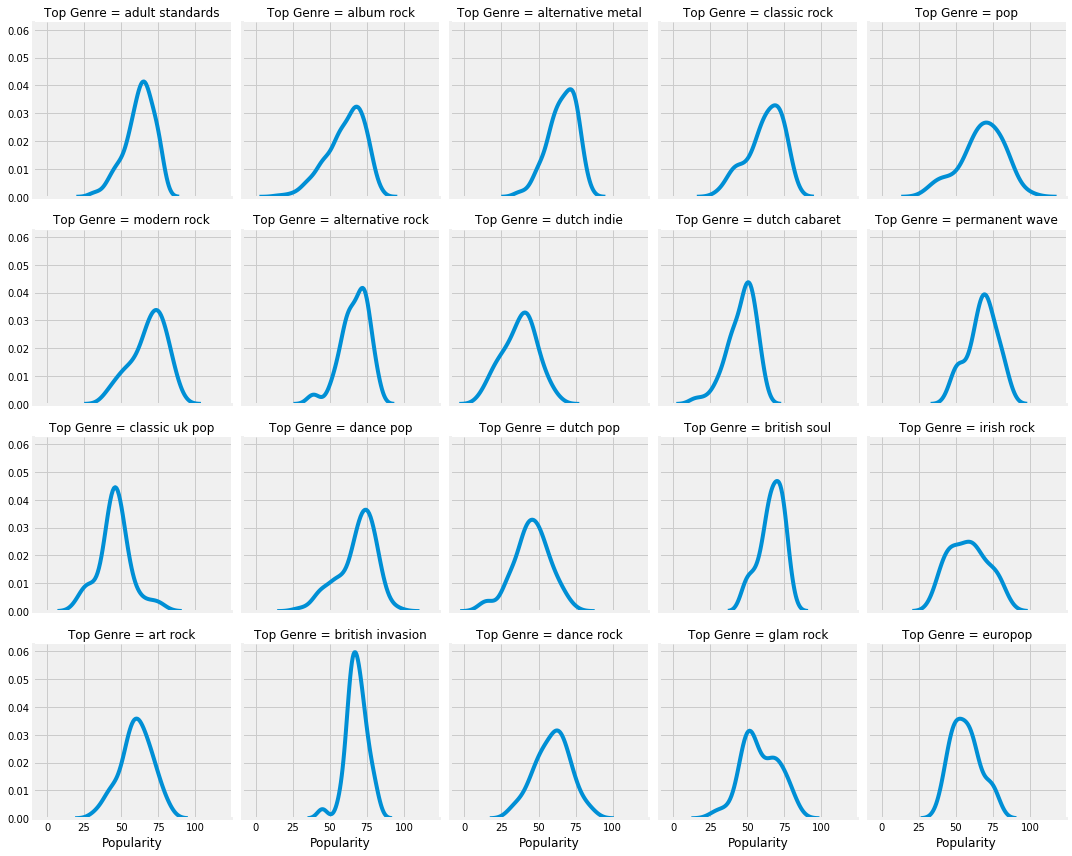

In [37]:
# Faceting is the act of breaking data variables up across multiple subplots 
# and combining those subplots into a single figure.
# In this case it will be the points of P1 per floor
g = sns.FacetGrid(df, col='Top Genre', col_wrap=5)
g = g.map(sns.kdeplot, 'Popularity')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f32a8f5dc10>,
      dtype=object)

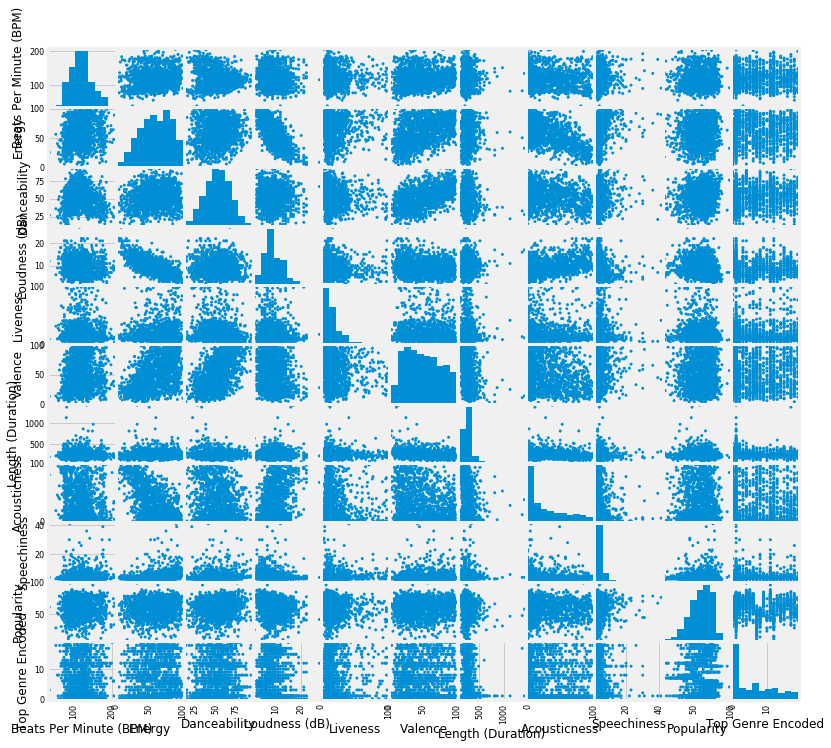

In [38]:
# Sparse matrix
fig, ax = plt.subplots(figsize=(12,12))
scatter_matrix(df.drop(['Top Genre'], axis=1), alpha=1, ax=ax)

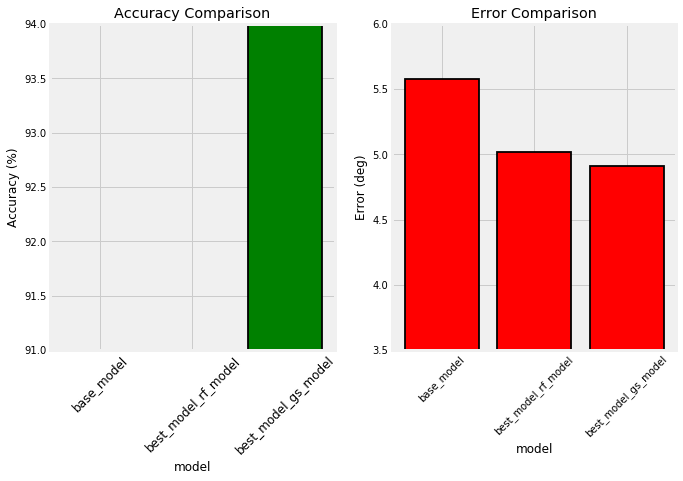

In [39]:
xvalues = list(range(len(comparison)))
plt.subplots(1, 2, figsize=(10, 6))
plt.subplot(121)
plt.bar(xvalues, comparison['accuracy'], color = 'g', edgecolor = 'k', linewidth = 1.8)
plt.xticks(xvalues, comparison['model'], rotation = 45, fontsize = 12)
plt.ylim(ymin = 91, ymax = 94)
plt.xlabel('model'); plt.ylabel('Accuracy (%)'); plt.title('Accuracy Comparison');

plt.subplot(122)
plt.bar(xvalues, comparison['error'], color = 'r', edgecolor = 'k', linewidth = 1.8)
plt.xticks(xvalues, comparison['model'], rotation = 45)
plt.ylim(ymin = 3.5, ymax = 6)
plt.xlabel('model'); plt.ylabel('Error (deg)'); plt.title('Error Comparison');
plt.show();

## Training Curves

### Changing Number of Trees

In [40]:
# We can perform grid search over only one parameter to observe the effects of changing that parameter on performance. 
# We will look at training time, training set accuracy, and testing set accuracy.
# Grid with only the number of trees changed
tree_grid = {'n_estimators': [int(x) for x in np.linspace(1, 301, 30)]}

# Create the grid search model and fit to the training data
tree_grid_search = GridSearchCV(best_grid, param_grid=tree_grid, verbose = 2, n_jobs=-1, cv = 3,
                                scoring = 'neg_mean_absolute_error', return_train_score=True)
tree_grid_search.fit(train_X, train_y);

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   11.9s finished


In [41]:
tree_grid_search

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=80, max_features=3, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=8,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=1, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_estimators': [1, 11, 21, 32, 42, 52, 63, 73, 83, 94, 104, 114, 125, 135, 145, 156, 166, 176, 187, 197, 207, 218, 228, 238, 249, 259, 269, 280, 290, 301]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_absolute_error', verbose=2)

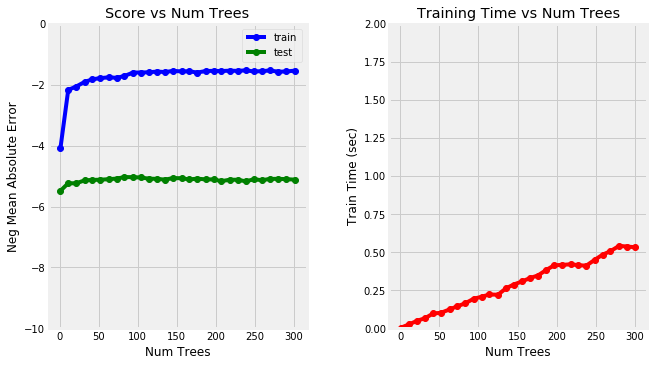

In [42]:
plot_results(tree_grid_search)

In [43]:
### Number of Features at Each Split

In [44]:
feature_grid = {'max_features': list(range(1, train_X.shape[1] + 1))}

In [45]:
# Create the grid search and fit on the training data
feature_grid_search = GridSearchCV(best_grid, param_grid=feature_grid, cv = 3, n_jobs=-1, verbose= 2,
                                  scoring = 'neg_mean_absolute_error', return_train_score=True)
feature_grid_search.fit(train_X, train_y);

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  23 out of  30 | elapsed:    1.0s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    1.3s finished


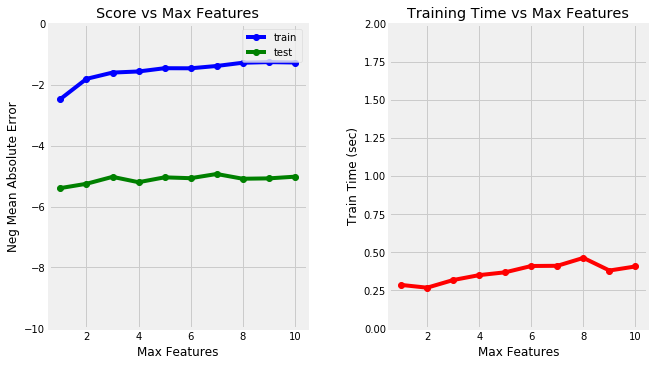

In [46]:
plot_results(feature_grid_search, param='max_features', name = 'Max Features')

# Plot model statistics

In [47]:
r2 = r2_score(test_y, validation_predictions)
mse = mean_squared_error(test_y, validation_predictions) 
mean_absolute_error = mean_absolute_error(test_y, validation_predictions) 
explained_variance = explained_variance_score(test_y, validation_predictions)
median_absolute_error = median_absolute_error(test_y, validation_predictions)
mean_squared_log_error = mean_squared_log_error(test_y, validation_predictions)

print('r2:',{round(r2,4)})
print('MSE:',{round(mse,4)})
print('RMSE:',{round(np.sqrt(mse),4)})
print('MAE:',{round(mean_absolute_error,4)})
print('explained_variance:',{round(explained_variance,4)})    
print('mean_squared_log_error:',{round(mean_squared_log_error,4)})

('r2:', set([-0.8619]))
('MSE:', set([63.3215]))
('RMSE:', set([7.9575]))
('MAE:', set([5.5777]))
('explained_variance:', set([0.0]))
('mean_squared_log_error:', set([1.7372]))


In [48]:
cross_val_score_ = cross_val_score(model, train_X, train_y, cv = 10, scoring = 'accuracy')
print('cross validation mean ',{cross_val_score_.mean()})
print('cross validation std ',{cross_val_score_.std()})

('cross validation mean ', set([0.28113771878024374]))
('cross validation std ', set([0.012450402195058137]))


In [49]:
y_randforest = cross_val_predict(model, train_X, train_y, cv = 10)
recall_score_ = recall_score(train_y, y_randforest, average = "micro")
precission_score_ = precision_score(train_y, y_randforest, average = "micro")
f1_score = 2 * (precission_score_ * recall_score_) / (precission_score_ + recall_score_)
print('Recall Score:',{recall_score_})
print('Precision Score:',{precission_score_})
print('F1 Score:', {f1_score})

('Recall Score:', set([0.28051001821493626]))
('Precision Score:', set([0.28051001821493626]))
('F1 Score:', set([0.28051001821493626]))


### Tree Visualization

In [50]:
# Extract single tree
estimator = best_grid.estimators_[5]
estimator

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=80,
            max_features=3, max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=3,
            min_samples_split=8, min_weight_fraction_leaf=0.0,
            presort=False, random_state=550290313, splitter='best')

In [51]:
column_names = list(df[features].columns.values)
class_names = list(df['Top Genre'].unique())

In [52]:
column_names

['Beats Per Minute (BPM)',
 'Energy',
 'Danceability',
 'Loudness (dB)',
 'Liveness',
 'Valence',
 'Length (Duration)',
 'Acousticness',
 'Speechiness',
 'Popularity']

In [53]:
# Export as dot file
export_graphviz(estimator, out_file='tree_depth_best_grid.dot', 
                feature_names = column_names,
                class_names = class_names,
                rounded = True, proportion = False, 
                precision = 2, filled = True)

In [54]:
# Convert to png using system command (requires Graphviz)
# python -m pip install graphviz
# python -m pip install pydot
(graph,) = pydot.graph_from_dot_file('tree_depth_best_grid.dot')
graph.write_png('tree_depth_best_grid.png')

# Display in jupyter notebook
Image(filename = 'tree_depth_best_grid.png')